In [3]:
import pandas as pd
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
%matplotlib inline


from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.metrics import make_scorer
# The scoring that is required, mape, is not implemented in Scikitlearn: we have to implement it.
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_score = make_scorer(mape)
import xgboost
import lightgbm as lgb


The goal of this challenge is to predict the volatility on the US stock market for different products.
More precisely, we are given their volatilities and returns between 9:30 a.m and 1:55 p.m, and we want to predict the average volatility of each of these products between 2pm and 4pm.

## E.D.A and Data preprocessing

### Data exploration

In [4]:
# Loading the training/testing input datasets: X_train, X_test
X_train = pd.read_csv('x_train.csv', sep=";")
X_train.index = X_train['ID']
X_train = X_train.drop('ID',axis=1)
display(X_train.head())

X_test = pd.read_csv('x_test.csv', sep=";")
X_test.index = X_test['ID']
X_test = X_test.drop('ID',axis = 1)
display(X_test.head())

# Loading the training input dataset Y
y_train = pd.read_csv('y_train.csv', sep=";")
y_train[['ID','TARGET']] = y_train['ID,TARGET'].str.split(",",expand=True)
y_train.drop(columns=['ID,TARGET'],inplace = True)
y_train.index = y_train['ID']
y_train = y_train['TARGET'].astype(float)
display(y_train.head())

# List of the times for volatility and return
volatility_col = X_train.columns[2:56]
return_col = X_train.columns[56:]

print(f'X_train shape: {X_train.shape}')
print(f'X_train shape: {y_train.shape}')

,date,product_id,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,volatility 10:05:00,...,return 13:10:00,return 13:15:00,return 13:20:00,return 13:25:00,return 13:30:00,return 13:35:00,return 13:40:00,return 13:45:00,return 13:50:00,return 13:55:00
ID,,,,,,,,,,,,,,,,,,,,,
1,1,1,0.662737,0.716896,0.698601,0.480172,0.623665,0.201876,0.327206,0.374239,...,1.0,1.0,1.0,-1.0,1.0,-1.0,0.0,1.0,1.0,-1.0
2,1,2,0.285394,0.379560,0.094858,0.094794,0.055315,0.173994,0.102745,0.079102,...,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0
3,1,3,1.151646,1.093562,1.833443,0.595823,0.310177,0.792310,0.401979,0.336490,...,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0
4,1,4,0.835260,0.329615,0.340366,0.216692,0.350371,0.247594,0.341194,0.175573,...,-1.0,1.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0
5,1,5,0.274185,0.061076,0.010168,0.060890,0.000000,0.213162,0.162763,0.203675,...,-1.0,1.0,1.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,0.0


,date,product_id,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,volatility 10:05:00,...,return 13:10:00,return 13:15:00,return 13:20:00,return 13:25:00,return 13:30:00,return 13:35:00,return 13:40:00,return 13:45:00,return 13:50:00,return 13:55:00
ID,,,,,,,,,,,,,,,,,,,,,
636314,2118,1,1.789785,0.331795,0.116128,0.149308,0.314758,0.248846,0.545911,0.115758,...,0.0,-1.0,-1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
636315,2118,2,0.476156,0.562543,0.437287,0.155260,0.084687,0.113053,0.113087,0.070637,...,-1.0,-1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,-1.0
636316,2118,3,0.311971,1.004342,0.868062,0.189651,0.566655,0.298565,0.235630,0.314808,...,1.0,-1.0,1.0,0.0,0.0,1.0,-1.0,1.0,1.0,-1.0
636317,2118,4,1.791920,0.502895,0.233128,0.197036,0.071677,0.125627,0.089803,0.378188,...,1.0,0.0,1.0,0.0,-1.0,1.0,0.0,1.0,1.0,0.0
636318,2118,5,0.339878,0.395725,0.526572,0.112837,0.018806,0.018806,0.263286,0.056418,...,1.0,1.0,1.0,1.0,-1.0,0.0,-1.0,-1.0,0.0,0.0


ID
1    0.134168
2    0.046126
3    0.144312
4    0.130176
5    0.085873
Name: TARGET, dtype: float64

X_train shape: (636313, 110)
X_train shape: (636313,)


We have been given the following information:
- <u>1 column</u> corresponding to the date of the measurement. 
- <u>1 column</u> corresponding to the id of the product we consider.
- <u>54 columns</u>: Each column corresponds to a 5 minutes interval, starting from 9:30 a.m and ending at 1:55pm, and is filled with the \textbf{volatility} taken by the stock in this interval. The volatility is the standard deviation of the prices of the stock on a given interval.
- <u>54 columns</u>: Each column corresponds to a 5 minutes interval, starting from 9:30 a.m and ending at 1:55pm, and is filled with the \textbf{return} on investment measured during this interval. The return is +1 or -1, depending on the price change during the five minutes period.
    
The training output file contains the target for each 'ID', where the target is the volatility of the same set of stocks and dates measured between 2:00pm and 4:00pm.

\textbf{A very important remark is that the column 'date' giving us the day of the measurement is not necessarily ordered.} This means, in particular, that we cannot treat the whole thing as a time series problem.

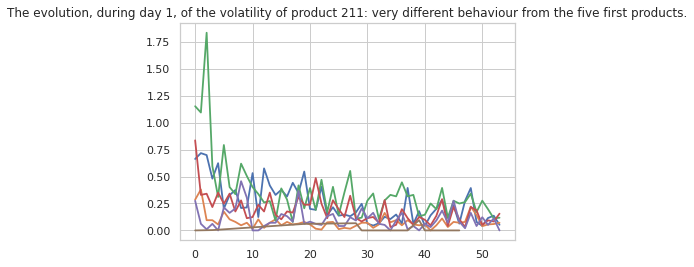

In [ ]:
volatility_day_one_five_first_products = X_train[(X_train['product_id'].isin([1,2,3,4,5])) & (X_train['date']==1)][volatility_col]
list_of_products_vol = [volatility_day_one_five_first_products.loc[i].values for i in range(1,6)]

date_range = np.arange(54)

for product_vol in list_of_products_vol:
    sns.lineplot(x=date_range,y=product_vol, linewidth=1.8).set_title('The evolution, during day 1, of the volatility of 5 different products.')


- As one could expect, the different products' variations are strongly correlated. Indeed, the economical context act similarily for most stocks, and thus, on their volatilities.

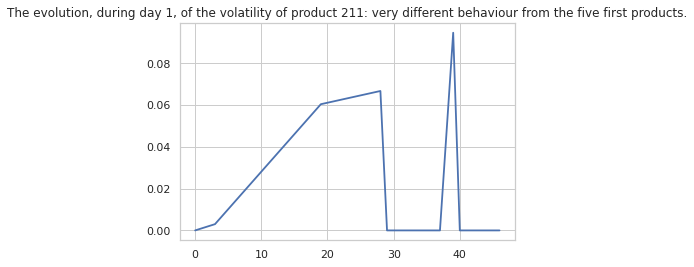

In [ ]:
volatility_day_one_five_first_products = X_train[(X_train['product_id'].isin([211])) & (X_train['date']==1)][volatility_col]
list_of_products_vol = [volatility_day_one_five_first_products.loc[i].values for i in [211]]

date_range = np.arange(54)

for product_vol in list_of_products_vol:
    sns.lineplot(x=date_range,y=product_vol, linewidth=1.8).set_title('The evolution, during day 1, of the volatility of product 211: very different behaviour from the five first products.')


- Looking at the products more closely, we find some behaviours that are really odd. This probably means that we will have to group products depending on their behaviour to optimize the prediction.


We now look at the distribution of the volatilities.

In [ ]:
X_train.describe()

,date,product_id,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,volatility 10:05:00,...,return 13:10:00,return 13:15:00,return 13:20:00,return 13:25:00,return 13:30:00,return 13:35:00,return 13:40:00,return 13:45:00,return 13:50:00,return 13:55:00
count,636313.000000,636313.000000,608222.000000,627558.000000,630656.000000,631557.000000,631777.000000,631501.000000,632508.000000,631853.000000,...,626321.000000,626998.000000,626938.000000,627065.000000,627895.000000,627707.000000,627567.000000,628083.000000,628147.000000,628642.000000
mean,1059.128210,160.248984,0.584382,0.477272,0.408130,0.362365,0.336104,0.308503,0.337733,0.294587,...,-0.004932,0.022227,0.002102,0.001214,-0.007946,-0.012997,-0.002698,0.001941,-0.008592,-0.008393
std,610.501769,92.014489,0.642999,0.496037,0.437281,0.377806,0.356739,0.323668,0.343424,0.315100,...,0.908353,0.909381,0.909945,0.909467,0.913197,0.912219,0.912355,0.912933,0.912810,0.914069
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,531.000000,81.000000,0.226861,0.192658,0.164098,0.144090,0.130837,0.120699,0.133030,0.114617,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,1058.000000,161.000000,0.423908,0.346012,0.294692,0.260319,0.238546,0.220700,0.240355,0.209278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1589.000000,241.000000,0.737118,0.599145,0.511246,0.454621,0.420426,0.388414,0.423885,0.370043,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2117.000000,318.000000,46.463028,22.345580,27.829934,18.600202,16.226835,20.255632,11.413828,17.792948,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- Looking at this, it is clear that we have outliers, the max value is way too high. This is not too problematic, however, as MAPE gives more importance to low values.

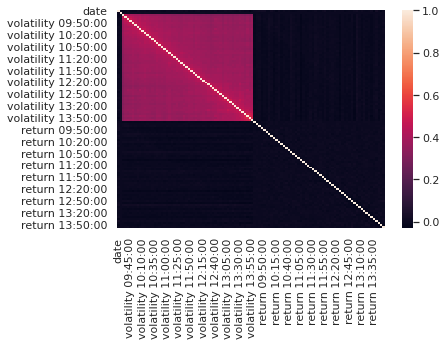

In [ ]:
sns.heatmap(X_train.corr());

- The correlation matrice allows us to tell which of the primitive variables are correlated. 

- We can read that most variables do not hold any correlation, however, there are relationships between the lines that correspond to volatilities.

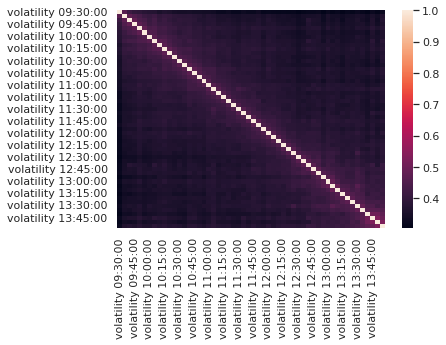

In [ ]:
sns.heatmap(X_train[volatility_col].corr());

- For a fixed date and a fixed product, volatilities are correlated les volatilités pour un produit.
- In particular, volatility at time $t$ is strongly linked to volatility at times $t+1$ and $t-1$

\textbf{ This means that, for our prediction, we should give more importance to the volatility at 1:45pm, 1:50pm and 1:55pm that the ones obtained at an earlier hour.}

In [5]:
pd.set_option('display.max_rows', None)
display(X_train.shape)
print('Percentage of nans:')
display((X_train.isnull().sum().sort_values()/X_train.shape[0])*100)
pd.set_option('display.max_rows',10)

(636313, 110)

Percentage of nans:


date                   0.000000
product_id             0.000000
return 10:00:00        0.597976
volatility 10:00:00    0.597976
volatility 10:05:00    0.700913
return 10:05:00        0.700913
volatility 09:50:00    0.712857
return 09:50:00        0.712857
volatility 10:10:00    0.715686
return 10:10:00        0.715686
volatility 10:15:00    0.734387
return 10:15:00        0.734387
volatility 09:45:00    0.747431
return 09:45:00        0.747431
volatility 09:55:00    0.756232
return 09:55:00        0.756232
return 10:30:00        0.758117
volatility 10:30:00    0.758117
return 10:20:00        0.789706
volatility 10:20:00    0.789706
volatility 10:35:00    0.841095
return 10:35:00        0.841095
return 10:25:00        0.846282
volatility 10:25:00    0.846282
return 11:00:00        0.880856
volatility 11:00:00    0.880856
volatility 09:40:00    0.889028
return 09:40:00        0.889028
volatility 10:40:00    0.896100
return 10:40:00        0.896100
return 10:45:00        0.905529
volatili

### Train/val/test split 

Since the data depends a lot on which day we are looking at, we have to take that into account when we split the dataset. We have been given X_train and X_test. In order to define X_val, we manually extract 10% of X_train, making sure that we do not mix one day in both datasets.

In [6]:
#Train/val split: do it by hand because of the date factor.
X_train.reset_index(level=0,inplace = True)
X_train.index +=1

index_val = np.random.choice(np.arange(1,2118),int(2117/10),replace = False)
index_train = np.array([index for index in range(1,2118)  if index not in index_val])
index_val.sort()
index_train.sort()

X_val = X_train[X_train['date'].isin(index_val)].sort_values(['date','product_id'])
X_train = X_train[X_train['date'].isin(index_train)].sort_values(['date','product_id'])

y_val = y_train.loc[y_train.index[X_val['ID']-1]]
y_train = y_train.loc[y_train.index[X_train['ID']-1]]

X_train.drop('ID',axis = 1,inplace = True)
X_val.drop('ID',axis = 1,inplace = True)

In [8]:
# To check that everythings works well
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]

### Treating N.a.n values

In general, we obtain a good result replacing missing values by the median of the other values.
However, when using MAPE as the scoring metric, linear interpolation happens to be more efficient.

In [7]:
for col in volatility_col:
    X_train[col].interpolate(limit_direction="both", inplace=True)
    X_val[col].interpolate(limit_direction="both", inplace=True)
    X_test[col].interpolate(limit_direction="both", inplace=True)
for col in return_col:
    X_train[col].interpolate(limit_direction="both", inplace=True)
    X_val[col].interpolate(limit_direction="both", inplace=True)
    X_test[col].interpolate(limit_direction="both", inplace=True)

### Benchmark

The most natural benchmarks, considering our previous analysis, would be to take the average of volatilities obtained during the rest of the day. We try different variations of this idea.

In [8]:
benchmark_mean = X_val[volatility_col].mean(axis = 1)
print(f'Mean of all measurements: {mape(y_val,benchmark_mean)}')

benchmark_mean_recent = (X_val[volatility_col[-20:]]).mean(axis = 1)
print(f'Mean of last 10 measurements: {mape(y_val,benchmark_mean_recent)}')


Mean of all measurements: 36.11698869858346
Mean of last 10 measurements: 27.131588218591528


## Features engineering

The main problem we face with this dataset is that the number of column is too high to allow fast computations of most powerful machine learning models. An idea to tackle this problem is to replace the columns by features that have been computed out of them and, we hope, will englobe enough of the information to provide a good result in the end. After several attempts, we decided to use the following features. There are 20 of them, dividing the original amount by 5.

**Features related to volatilities:**

- Last 5 volatilities in the day (since the most important data are the ones close to 2 p.m);
- Average of all volatilities in the day;
- Average of the last 10 volatilities in the day;
- Exponential weighted moving average of all volatilities  in the day;
- Standard deviation of all volatilities in the day;
- Maximum of volatilities in the day;
- Minimum of volatilities in the day;
- Kurtosis of volatilities in the day;

**Features related to the derivative of volatilities :**

- Average of all differences between the volatilities measured at the date $t$ and $t+1$.
- Standard deviation of all differences between the volatilities measured at the date $t$ and $t+1$.
- Maximum of all differences between the volatilities measured at the date $t$ and $t+1$.
- Minimum of all differences between the volatilities measured at the date $t$ and $t+1$.
- The difference between the volatilities measured at 1:55 pm and 1:50pm.

**Features related to returns:**
- Average of all returns in the day;
- Standard deviation of all returns in the day;
- Last return in the day.

In [9]:
## Features engineering

for df in [X_train,X_val,X_test]:
    df['volatility_from_end_0'] = df[volatility_col].iloc[:, -1]
    for i in range(1,5):
        df[f'volatility_from_end_{i}'] = df[volatility_col].iloc[:, -(i+1):-i]
    df['volatility_mean'] = df[volatility_col].mean(axis = 1)
    df['volatility_mean_last_10'] = (df[volatility_col].iloc[:, -10:]).mean(axis = 1)
    df['volatility_ewm'] = df[volatility_col].ewm(alpha=0.7, min_periods=0, axis=1).mean().mean(axis=1)

    df['volatility_std'] = df[volatility_col].std(axis = 1)
    df['volatility_kurtosis'] = df[volatility_col].kurtosis(axis = 1)
    df['volatility_max'] = df[volatility_col].max(axis = 1)
    df['volatility_min'] = df[volatility_col].min(axis = 1)
 
    df['volatility_diff_mean'] = df[volatility_col].diff(periods = 1, axis = 1).mean(axis=1)
    df['volatility_diff_std'] = df[volatility_col].diff(periods = 1, axis = 1).std(axis=1)
    df['volatility_diff_max'] = df[volatility_col].diff(periods = 1, axis = 1).max(axis=1)
    df['volatility_diff_min'] = df[volatility_col].diff(periods = 1, axis = 1).min(axis=1)
    df['volatility_diff_last']= df[volatility_col].diff(periods = 1, axis = 1).iloc[:,-1:]

    df['last_return'] = df[volatility_col].iloc[:, -1:]
    df['return_mean'] = df[return_col].mean(axis = 1)
    df['return_std'] = df[return_col].std(axis = 1)
    df.drop(columns = volatility_col, inplace = True)
    df.drop(columns = return_col, inplace = True)
  


## Model 

In order to make the prediction, we produce several regression models and compute their averages (this is the idea of ensemble methods). We fine-tuned each of these models by Gridsearch or Randomsearch with cross-validation (5 splits).

We list the algorithms we used, their respective scores on the validation set and their execution time:
- Ridge regression: **27.968**  (1 second)
- Elasticnet : **28.119**     (3 seconds)
- LightGBM: **27.498**          (43 seconds)
- XgBoost regressor: **27.200**   (24 minutes)


The model consisting in considering the average of the predictions of these models gives a score of **25.882**.

In [21]:
model_ridge = Ridge()
model_ridge.fit(X_train,y_train)
model_eNet = ElasticNet(max_iter=5,alpha=0.01,l1_ratio=0.1)
model_eNet.fit(X_train, y_train)
model_lgbm = lgb.LGBMRegressor(colsample_bytree= 0.9783293844433719,
                                   learning_rate= 0.03,
                                   max_depth= 3,
                                   min_child_samples= 426,
                                   min_child_weight= 10.0,
                                   n_estimators= 200,
                                   num_leaves= 13,
                                   reg_alpha= 0,
                                   reg_lambda= 0.1,
                                   subsample= 0.40945817229114534)
model_lgbm.fit(X_train,y_train)
model_xgboost = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.08, subsample=0.75,colsample_bytree=1, max_depth=7)
model_xgboost.fit(X_train, y_train, eval_metric=mape)

def model_final_pred(X):
    result = (model_ridge.predict(X)+model_eNet.predict(X)+model_lgbm.predict(X)+model_xgboost.predict(X))/4
    y_test = pd.Series(result,name='TARGET')
    y_test.index += 1
    y_test.index.name = 'ID'
    return y_test.reset_index()

def model_final_score(X,y):
    return mape(y,model_final_pred(X))


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.322e+03, tolerance: 1.349e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[06:53:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [24]:
model_final_score(X_val,y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.445e+03, tolerance: 1.388e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


[22:08:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


25.882438926376427

In [31]:
y_test = model_final_pred(X_test)
y_test.to_csv('/content/drive/My Drive/y_test.csv', index=False))